<a href="https://colab.research.google.com/github/onkar201988/google_colab_tutorials/blob/main/Traffic_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


in Python, the serilized data is stored in 'Picked' file, .p. Leter unpickeling gives us de-serialized data.

In [46]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
np.random.seed(0)
import pickle
import pandas as pd #to load data from .csv
import random
from keras.src.legacy.preprocessing.image import ImageDataGenerator

In [48]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [49]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
# the data is (x, 32, 32, 3) which is 32x32 image with depth of 3, which is RGB color and not the grayscale

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [50]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images are not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images are not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images are not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), " The dimentions of the image is not 32x32x3"
assert(X_val.shape[1:] == (32, 32, 3)), " The dimentions of the image is not 32x32x3"
assert(X_test.shape[1:] == (32, 32, 3)), " The dimentions of the image is not 32x32x3"

In [51]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

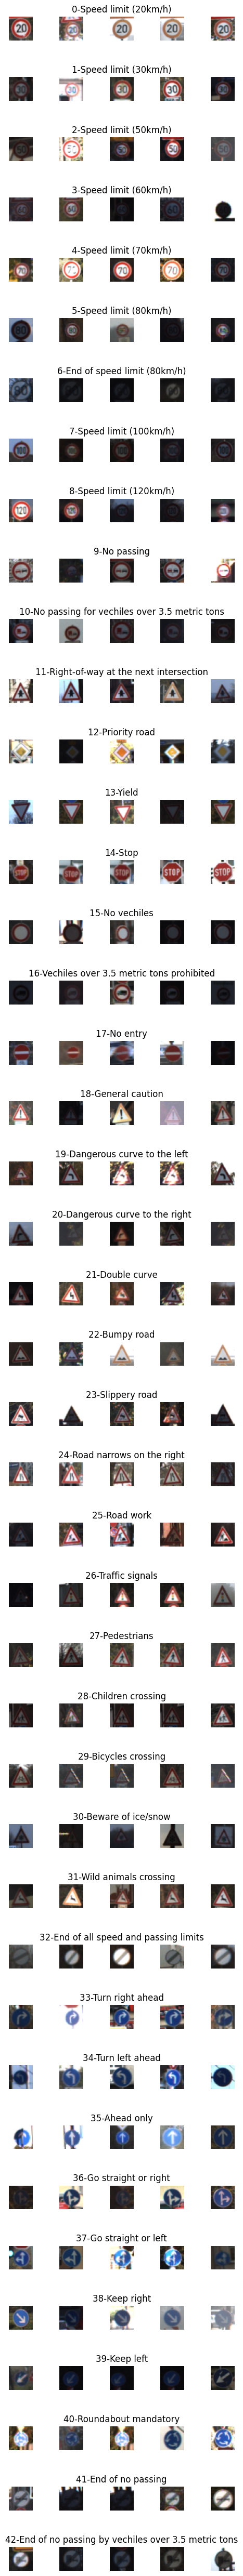

In [52]:
number_of_samples = []

cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()    #this will tidy up the plots
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected-1)), :, :], cmap=plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i ==2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      number_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

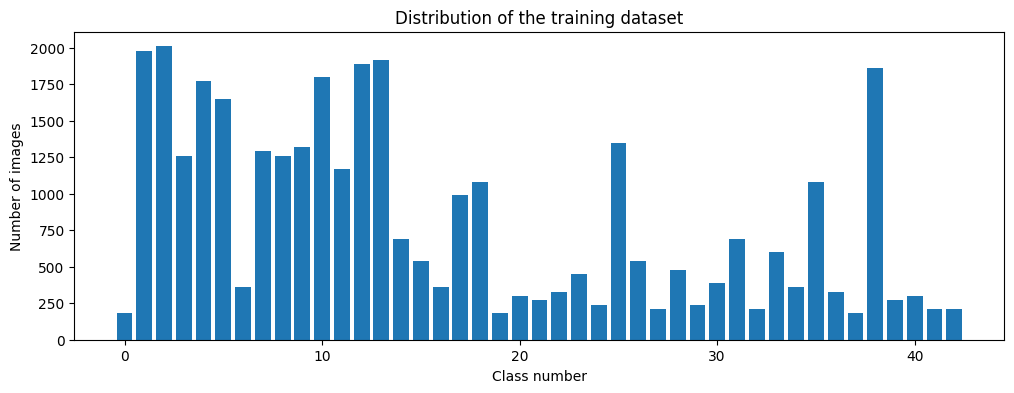

In [53]:
print(number_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), number_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


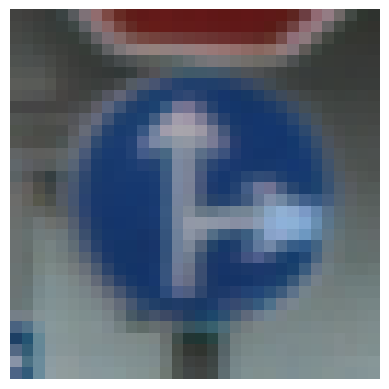

In [54]:
import cv2

plt.imshow(X_train[1100])
plt.axis("off")
print(X_train[1100].shape)
print(y_train[1100])

(32, 32)


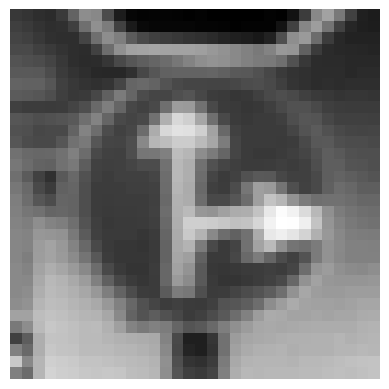

In [55]:
#since the sign dataset has images with different background and different lighting conditions, let's preprocess them to make them similar to each other.
# 1st we will convert them into gray-scale. The sign has information in it's shape and not in the color, so we are not loosing muchj information
# another benefit of doing this is now out model will have less complexility from depth of 3 to depth of 1, which will make our model efficient.

def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1100])
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

(32, 32)


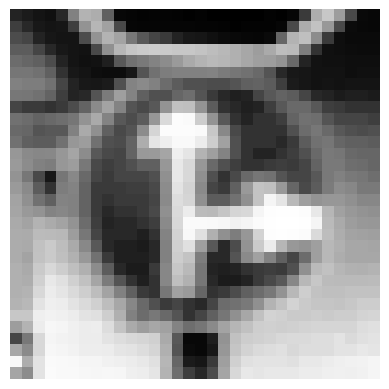

In [56]:
# now next step would be to equalize the histogram, that way we will normalize the brightness in all the images and enhances the contrast in the image.
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)


In [57]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255 #normalize the image, devide by 255
  return img

X_train = np.array(list(map(preprocessing, X_train))) #map iterates through the dataset with provided function, convert it to list, and later to array
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


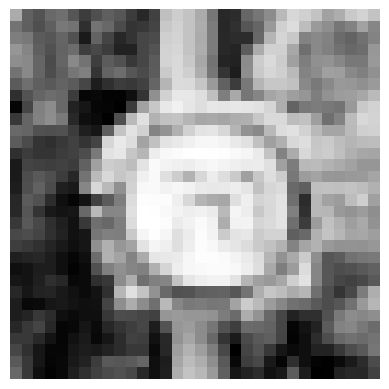

In [58]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap=plt.get_cmap("gray"))
plt.axis("off")
print(X_train.shape)

In [59]:
shape = X_train.shape
shape[0], shape[1], shape[2], 1

(34799, 32, 32, 1)

Bellow cells could be arranged using the data from variables, not hardcoding

In [60]:
# reshape the data to add depth of 1
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [61]:
# to improve the model more, we will implement the data augmentation process, by re-using the dataset and modifying it to create more data
# like to rotate the image, zoom the image, and so on.


datagen = ImageDataGenerator(width_shift_range =0.1,
                   height_shift_range = 0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)
datagen.fit(X_train)

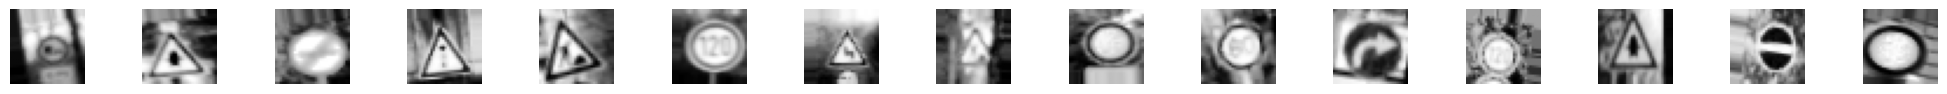

In [62]:
batches = datagen.flow(X_train, y_train, batch_size=20) # returns iterator
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32), cmap=plt.get_cmap("gray"))
  axs[i].axis('off')

In [63]:
# one hot encoding to the dataset
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [64]:
print(y_train[100])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [65]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation='relu')) # 2nd we doubled the filters
  model.add(Conv2D(60, (5, 5), activation='relu')) # 3rd we added one more convolutional layers
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu')) # 2nd we doubled the filters
  model.add(Conv2D(30, (3, 3), activation='relu')) # 3rd we added one more convolutional layers
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #model.add(Dropout(rate=0.5))                      # 4th, we added new dropout layer to reduce overfitting the val data.

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) # as 1st improvement, we changed the learning rate from 0.01 to 0.001
  return model

# **To improve our model from leNet model, we did following modifications.**
1. as 1st improvement, we changed the learning rate from 0.01 to 0.001
2. 2nd we doubled the filters
3. 3rd we added one more convolutional layers
4. 4th, we added new dropout layer to reduce overfitting the val data.

In [66]:
model = modified_model()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [67]:
#history = model.fit(x=X_train, y=y_train, verbose=1, validation_data=(X_val, y_val), epochs=10, batch_size=400, shuffle=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=True)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 695/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.2800 - loss: 2.6473

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.4165 - loss: 2.0970 - val_accuracy: 0.9054 - val_loss: 0.3148
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8171 - loss: 0.5950 - val_accuracy: 0.9528 - val_loss: 0.1341
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8927 - loss: 0.3508 - val_accuracy: 0.9637 - val_loss: 0.1011
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9170 - loss: 0.2648 - val_accuracy: 0.9737 - val_loss: 0.0719
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9331 - loss: 0.2175 - val_accuracy: 0.9771 - val_loss: 0.0796
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9445 - loss: 0.1829 - val_accuracy: 0.9810 - val_loss: 0.0594
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9503 - loss: 0.1652 - val_accuracy: 0.9837 - val_loss: 0.0543
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9540 - loss: 0.1435 - val

Text(0.5, 0, 'epoch')

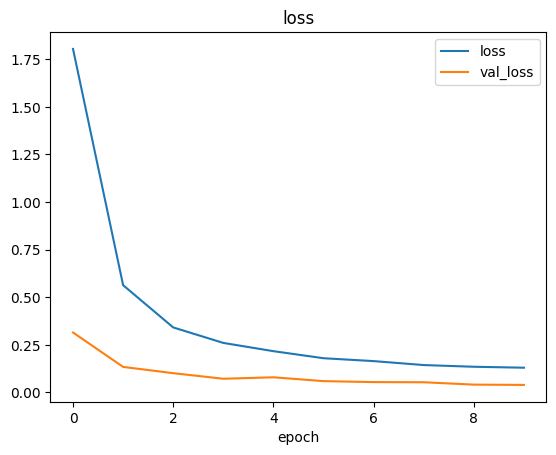

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

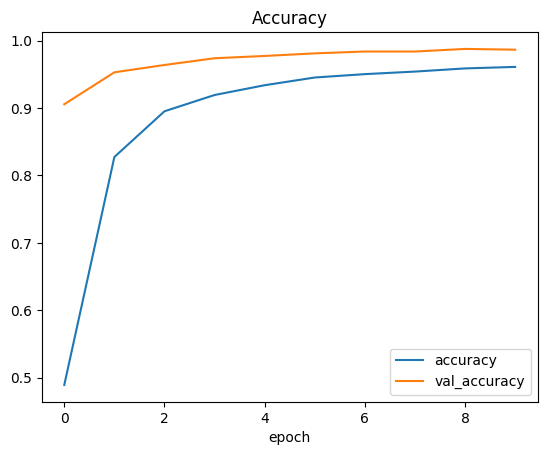

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [70]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score =', score[0])
print('Accuracy =', score[1])

<class 'list'>
Test score = 0.10340971499681473
Accuracy = 0.9702296257019043


# lets now test some images from internet to verify our model

https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg

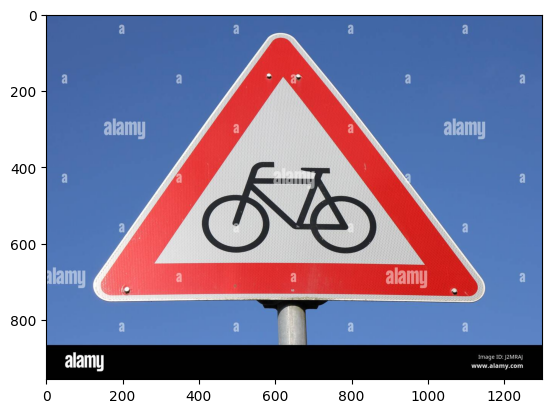

In [75]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[1.7710429e-09 3.4030803e-09 4.4848469e-10 1.4033289e-09 1.7912025e-12
  6.0634829e-07 2.0787767e-10 1.8599362e-08 1.7333595e-07 8.1058857e-07
  3.1213714e-09 2.9172329e-04 1.1587434e-07 4.6981208e-12 7.2224199e-11
  5.5280789e-12 3.2966394e-11 3.3293465e-11 6.7489871e-09 1.8320074e-02
  1.0691274e-04 1.1149296e-03 2.0940914e-05 4.2121867e-03 2.9701696e-04
  5.0303870e-04 4.4220293e-08 4.0034360e-05 1.4236169e-04 6.9613922e-01
  2.7880347e-01 4.2491720e-07 1.2249936e-12 1.7868016e-11 5.2252123e-08
  1.4986484e-06 1.6141061e-10 7.8714450e-08 4.1877715e-06 3.5685868e-10
  8.1023117e-08 3.4557528e-14 2.3862472e-12]]
predicted sign: [29]


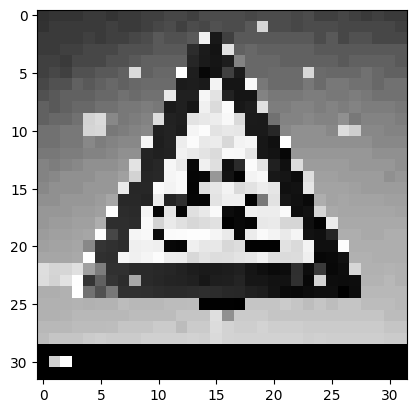

In [76]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

#Reshape reshape

img = img.reshape(1, 32, 32, 1)


#Test image
prediction = model.predict(img)
print(prediction)
predicted_digit=np.argmax(prediction,axis=1)
print('predicted sign:', predicted_digit)